In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
inspector = inspect(engine)

In [10]:
inspector.get_table_names()

['measurement', 'station']

In [11]:
columns = inspector.get_columns('measurement')

for info in columns:
    print(info["name"], info["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
#most recent is 2017-08-03
most_recent = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

# Calculate the date one year from the last date in data set.
#one_yearago is 2016-8-24
one_yearago = dt.date(2017, 8, 23) - dt.timedelta(days=364)

# Perform a query to retrieve the data and precipitation scores
year_rainamount = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_yearago).\
order_by(Measurement.date).all()

In [13]:
one_yearago

datetime.date(2016, 8, 24)

In [14]:
precip_df = pd.DataFrame(year_rainamount, columns=['Date', 'Precipitation'])
precip_df.set_index('Date', inplace=True)
precip_df = precip_df.dropna()

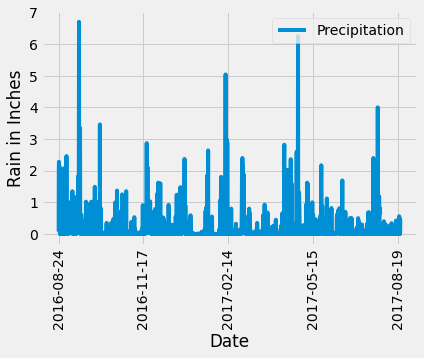

In [15]:
# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot()
plt.xlabel("Date")
plt.ylabel("Rain in Inches")
plt.xticks(rotation=90)
plt.legend(["Precipitation"],loc = "upper right")
plt.show()

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [17]:
# Design a query to calculate the total number stations in the dataset
numb_locations = session.query(Station).count()
print(f'There are {numb_locations} stations in this data')

There are 9 stations in this data


In [18]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.

stations_activity = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station)\
.order_by(func.count(Measurement.tobs).desc()).all()
stations_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
min_temp = session.query(func.min(Measurement.tobs)).group_by(Measurement.station).filter(Measurement.station=='USC00519281').all()

max_temp = session.query(func.max(Measurement.tobs)).group_by(Measurement.station).filter(Measurement.station=='USC00519281').all()
avg_temp = session.query(func.avg(Measurement.tobs)).group_by(Measurement.station).filter(Measurement.station=='USC00519281').all()

print(f'The min temp is {min_temp}, the max temp {max_temp}, and the average temp {avg_temp}')

The min temp is [(54.0,)], the max temp [(85.0,)], and the average temp [(71.66378066378067,)]


In [20]:
# Using the most active station id
top_station = stations_activity[0][0]

In [39]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
top_station_pastyear = session.query(Measurement.tobs).filter(Measurement.date > one_yearago)\
.filter(Measurement.station==top_station).all()


In [42]:
top_station_tempdf = pd.DataFrame(top_station_pastyear, columns=['Temp'])
top_station_tempdf.head()

,Temp
0,80.0
1,80.0
2,75.0
3,73.0
4,78.0


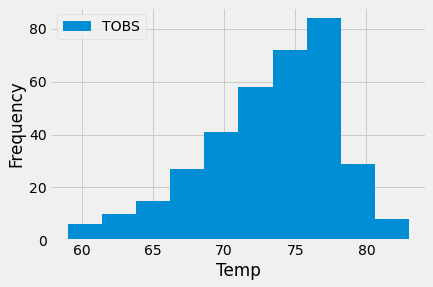

In [36]:
top_station_tempdf.plot.hist()
plt.legend(["TOBS"],loc = "upper left")
plt.xlabel("Temp")
plt.ylabel("Frequency")
plt.show()

# Close session

In [43]:
# Close Session
session.close()